<a href="https://colab.research.google.com/github/victorsenoguchi/MAC0460---Introduction-to-Machine-Learning/blob/main/ep04_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
name = "Victor Senoguchi Borges"  # write YOUR NAME
 
honorPledge = "I affirm that I have not given or received any unauthorized " \
              "help on this assignment, and that this work is my own.\n"
 
 
print("\nName: ", name)
print("\nHonor pledge: ", honorPledge)


Name:  Victor Senoguchi Borges

Honor pledge:  I affirm that I have not given or received any unauthorized help on this assignment, and that this work is my own.



## Libraries Version

Python 3.7.11 \\
numpy version 1.19.5 \\
pandas version 1.1.5 \\
sklearn version 0.22.2.post1 \\
tensorflow version 2.5.0 \\
matplotlib version 3.2.2 \\


# 0. Initial Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
 
%matplotlib inline

# 1. Dataset Preparation

## 1.1. Data Loading

In [ ]:
(X_train_ori, y_train_ori), (X_test_ori, y_test_ori) = mnist.load_data()
 
print(X_train_ori.shape, y_train_ori.shape)
print(X_test_ori.shape, y_test_ori.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## 1.2. Data Visualization

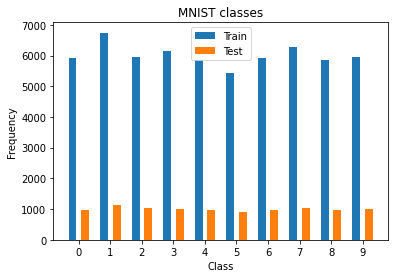

In [ ]:
labels = ["%s"%i for i in range(10)]
 
unique, counts = np.unique(y_train_ori, return_counts=True)
uniquet, countst = np.unique(y_test_ori, return_counts=True)
 
fig, ax = plt.subplots()
rects1 = ax.bar(unique - 0.2, counts, 0.25, label='Train')
rects2 = ax.bar(unique + 0.2, countst, 0.25, label='Test')
ax.legend()
ax.set_xticks(unique)
ax.set_xticklabels(labels)
 
plt.title('MNIST classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

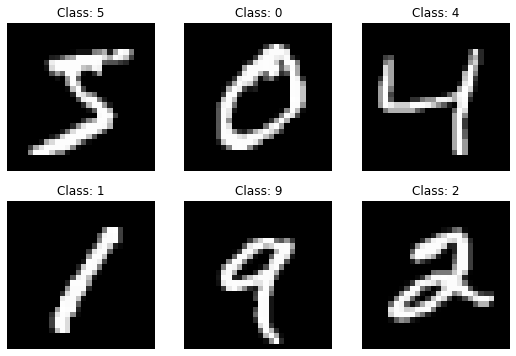

In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))
 
for i in range(6):
    ax[i//3, i%3].imshow(X_train_ori[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

## 1.3. Image Processing

In [ ]:
# Reduce the image size to its half 
X = np.array([image[::2, 1::2] for image in X_train_ori])
X_test = np.array([image[::2, 1::2] for image in X_test_ori])
 
y = y_train_ori
y_test = y_test_ori

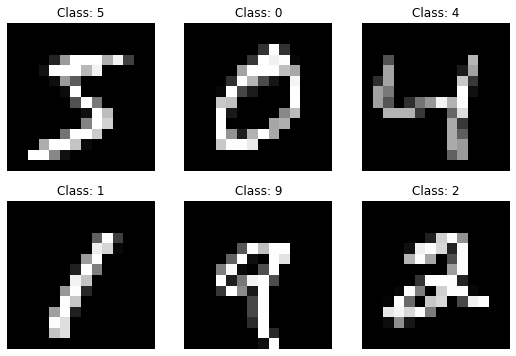

In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))
 
for i in range(6):
    ax[i//3, i%3].imshow(X[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

In [ ]:
X = (X/255.0).astype('float32').reshape((60000,14*14))
X_test = (X_test/255.0).astype('float32').reshape((10000,14*14))
 
print(X.dtype)
print(X_test.dtype)
 
print("\nShape of X: ", X.shape)
print("Shape of X_test: ", X_test.shape)
 
print("\nMinimum value in X:", np.amin(X))
print("Maximum value in X:", np.amax(X))
 
print("\nMinimum value in X_test:", np.amin(X_test))
print("Maximum value in X_test:", np.amax(X_test))

float32
float32

Shape of X:  (60000, 196)
Shape of X_test:  (10000, 196)

Minimum value in X: 0.0
Maximum value in X: 1.0

Minimum value in X_test: 0.0
Maximum value in X_test: 1.0


## 1.4. Dataset Split

This section divides the dataset into the training and validation set together in a stratified manner.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit

In [ ]:
# Create a list of indices
indices = np.arange(X.shape[0])

# Split the data in training and validation set
X_train, X_val, y_train, y_val, idx, _ = train_test_split(X, 
                                                          y, 
                                                          indices,
                                                          stratify = y,
                                                          train_size = 0.7, 
                                                          random_state = 2021)
 
# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in idx else 0 for x in indices]
 
# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

## 1.5. Splitted Data Visuallization

This section plots a histogram to show that the data is stratified.

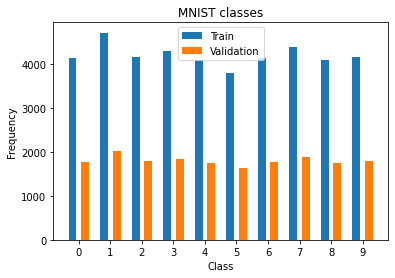

In [ ]:
labels = ["%s"%i for i in range(10)]
 
unique, counts = np.unique(y_train, return_counts=True)
uniquet, countst = np.unique(y_val, return_counts=True)
 
fig, ax = plt.subplots()
rects1 = ax.bar(unique - 0.2, counts, 0.25, label='Train')
rects2 = ax.bar(unique + 0.2, countst, 0.25, label='Validation')
ax.legend()
ax.set_xticks(unique)
ax.set_xticklabels(labels)
 
plt.title('MNIST classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# 2. Training, Evaluation and Selecting Models

##### Evaluation and Selection Methods Imports

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [ ]:
# Scorings to help select a model
scoring = {"accuracy" : make_scorer(accuracy_score),
           "precision": make_scorer(precision_score, average = "macro"),
           "recall": make_scorer(recall_score, average = "macro"),
           "f1" : make_scorer(f1_score, average = "macro")}
 
# Random_state argument
seed = 199
 
# Max number of iterations
epochs = 1000

##### Deciding Functions

Two functions to help me decide some model parameters 

In [ ]:
def make_grid(model, param_grid, scoring, X, y, pds):
   
   gs = GridSearchCV(estimator = model,
                     scoring = scoring,
                     cv = pds,
                     param_grid = param_grid,
                     verbose = True,
                     n_jobs = -1,
                     refit = False).fit(X, y)
 
   grid = pd.DataFrame(gs.cv_results_)
 
   grid.rename(columns = {"rank_test_accuracy": "accuracy_rank",
                          "mean_test_accuracy": "accuracy",
                          "rank_test_precision": "precision_rank",
                          "mean_test_precision": "precision",
                          "rank_test_recall": "recall_rank",
                          "mean_test_recall": "recall",
                          "rank_test_f1": "f1_rank",
                          "mean_test_f1": "f1"},
               inplace = True)
 
   grid.sort_values(by = ["accuracy_rank", 
                          "f1_rank"],
                    inplace = True)
  
   return grid[["params", "accuracy_rank", 
                "accuracy", "f1_rank",
                "f1", "precision",
                "recall"]]
 
def select(grid, param = None):
   if param is None:
      return grid["params"].iloc[0]
   else:
      return grid["params"].iloc[0][param]

## 2.1. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

#### 2.1.1. Model Selection

##### Deciding a Solver

  As a lot of parameters depends on the solver, I decided to choose a solver first.

In [ ]:
solver = ["newton-cg", "lbfgs", 
          "sag", "saga"]
 
param_grid = dict(solver = solver)
 
model = LogisticRegression(random_state = seed,
                           max_iter = epochs)
 
lr_solver_grid = make_grid(model, param_grid, 
                           scoring, X, y, pds)
 
lr_solver_grid.head()

Fitting 1 folds for each of 4 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
lr_solver = select(lr_solver_grid,   
                   "solver")

##### Deciding Other Parameters

  GridSearchCV to decide a C and penalty parameters.

In [ ]:
C = [10**(i-3) for i in range(7)]
 
penalty = ["l1", "l2"]
 
param_grid = dict(C = C,
                  penalty = penalty)
 
model = LogisticRegression(random_state = seed,        
                           max_iter = epochs,
                           solver = lr_solver)
                      
lr_grid = make_grid(model, param_grid,                          
                    scoring, X, y, pds)
 
lr_grid.head()

In [ ]:
lr_params = select(lr_grid)

#### 2.1.2. Model Training

In [ ]:
lr = LogisticRegression(random_state = seed,        
                        max_iter = epochs,
                        solver = lr_solver,
                        penalty = lr_params["penalty"],
                        C = lr_params["C"])
 
lr.fit(X_train, y_train)

#### 2.1.3. Model Evaluation

In [ ]:
print("Logistic Regression\n")
 
yhat_lr_train = lr.predict(X_train)
lr_train_acc = accuracy_score(y_train,
                              yhat_lr_train)
print("Training Score:", lr_train_acc)
print()
 
yhat_lr_val = lr.predict(X_val)
lr_val_acc = accuracy_score(y_val,
                            yhat_lr_val)
print("Validation Score:", lr_val_acc)
print()
 
print("Validation Report:\n")
print(classification_report(y_val, yhat_lr_val))

## 2.2. SVM Classifier

In [ ]:
from sklearn.svm import SVC

#### 2.2.1. Model Selection

##### Deciding the Best Degree for Polynomial Kernel

In [ ]:
degree = [i for i in range(2, 6)]
 
param_grid = dict(degree = degree)
 
model = SVC(random_state = seed,        
            max_iter = epochs,
            kernel = "poly")
 
poly_degree_grid = make_grid(model, param_grid,
                             scoring, X, y, pds)
 
poly_degree_grid.head()

In [ ]:
poly_degree = select(poly_degree_grid, "degree")

##### Deciding a Kernel

As a lot of parameters depends on the svm kernel, I decided to choose a kernel first.

In [ ]:
kernel = ["linear", "rbf", "poly"]
 
param_grid = dict(kernel = kernel)
 
model = SVC(random_state = seed,        
            max_iter = 1000,
            degree = poly_degree)
 
svm_kernel_grid = make_grid(model, param_grid,
                            scoring, X, y, pds)
 
svm_kernel_grid.head()

In [ ]:
svm_kernel = select(svm_kernel_grid,
                    "kernel")

##### Deciding Other Parameters

GridSearchCV to decide a C and gamma parameters.


In [ ]:
kernel = grid["params"].iloc[0]["kernel"]
 
C = [10**(i-1) for i in range(3)]
 
gamma = C + ["scale", "auto"]
 
param_grid = dict(C = C,
                  gamma = gamma)
 
model = SVC(random_state = seed, 
            kernel = svm_kernel, 
            degree = poly_degree,      
            max_iter = epochs)
 
svm_grid = make_grid(model, param_grid,
                     scoring, X, y, pds)
 
svm_grid.head()

In [ ]:
svm_params = select(svm_grid)

#### 2.2.2. Model Training

In [ ]:
svm = SVC(random_state = seed,   
          kernel = kernel, 
          degree = degree,
          max_iter = epochs,
          C = svm_params["C"],
          gamma = svm_params["gamma"])
 
svm.fit(X_train, y_train)

#### 2.2.3. Model Evaluation

In [ ]:
print("SVM Classifier\n")
 
yhat_svm_train = svm.predict(X_train)
svm_train_acc = accuracy_score(y_train, 
                               yhat_svm_train)
print("Training Score:", svm_train_acc)
print()
 
yhat_svm_val = svm.predict(X_val)
svm_val_acc = accuracy_score(y_val, 
                             yhat_svm_val)
print("Validation Score:", svm_val_acc)
print()
 
print("Validation Report:\n")
print(classification_report(y_val, yhat_svm_val))

## 2.3. Neuron Network (MLP Classifier)

In [ ]:
 from sklearn.neural_network import MLPClassifier

#### 2.3.1. Model Selection

##### Deciding a Solver

As a lot of parameters depends on the solver, I decided to choose a solver first.

In [ ]:
solver = ["lbfgs", "sgd", "adam"]
 
param_grid = dict(solver = solver)
 
model = MLPClassifier(random_state = seed,        
                      max_iter = epochs)
 
mlp_solver_grid = make_grid(model, param_grid,
                            scoring, X, y, pds)
 
mlp_solver_grid.head()

In [ ]:
mlp_solver = select(mlp_solver_grid,
                    "solver")

##### Deciding an Activation Function

To avoid waste time training a lot of models with a activation function that does not work, I decide to pick one before.

In [ ]:
activation = ["relu", "tanh", "identity", "logistic"]
 
param_grid = dict(activation = activation)
 
model = MLPClassifier(random_state = seed,
                      max_iter = epochs,
                      solver = mlp_solver)
                           
mlp_act_grid = make_grid(model, param_grid,
                         scoring, X, y, pds)
 
mlp_act_grid.head()

In [ ]:
mlp_act = select(mlp_act_grid,
                 "activation")

##### Deciding Other Parameters

GridSearchCV to decide a alpha and learning rate init parameters.

In [ ]:
alpha = [1e-2 + (i-2) * 0.005 for i in range(5)]

learning_rate_init = [1e-3 * (1+i*0.5) for i in range(3)]
 
param_grid = dict(alpha = alpha,
                  learning_rate_init = learning_rate_init)
                     
model = MLPClassifier(random_state = seed,        
                      max_iter = epochs,
                      solver = mlp_solver,
                      activation = mlp_act)

mlp_grid = make_grid(model, param_grid,
                     scoring, X, y, pds)

mlp_grid.head()

In [ ]:
mlp_params = select(mlp_grid)

#### 2.3.2. Model Training

In [ ]:
mlp = MLPClassifier(random_state = seed,        
                    max_iter = epochs,
                    solver = mlp_solver,
                    activation = mlp_act,
                    alpha = params["alpha"],
                    activation = params["activation"])

mlp.fit(X_train, y_train)

#### 2.3.3. Model Evaluation

In [ ]:
print("Neural Network (MLP Classifier) \n")
 
yhat_mlp_train = mlp.predict(X_train)
mlp_train_acc = accuracy_score(y_train, 
                               yhat_mlp_train)
print("Training Score:", mlp_train_acc)
print()
 
yhat_mlp_val = mlp.predict(X_val)
mlp_val_acc = accuracy_score(y_val, 
                             yhat_mlp_val)
print("Validation Score:", mlp_val_acc)
print()
 
print("Validation Report:\n")
print(classification_report(y_val, yhat_mlp_val))

# 3. Model Selection

## 3.1. Best Model Selection

Select between the Logist Regression, SVM and MLP models using the accuracy in the validation set.

In [ ]:
cands = {lr: (lr_train_acc, lr_val_acc),
         svm: (svm_train_acc, svm_val_acc),
         mlp: (mlp_train_acc, mlp_val_acc)}

cands = sorted(cands.items(),
               key = lambda cand: cand[1][1],
               reverse = True)
 
clf = cands[0][0]

## 3.2 Model Training

In [ ]:
clf.fit(X, y)

In [ ]:
clf

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=199, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

# 4. Error Estimation

## 4.1 Model Score

In [ ]:
if clf == mlp:
   print("Neural Network (MLP Classifier) \n")
elif clf == svm:
   print("SVM Classifier\n")
elif clf == lr:
   print("Logistic Regression\n")

yhat_clf_train = mlp.predict(X)
clf_train_acc = accuracy_score(y, 
                               yhat_clf_train)
print("Training Score:", clf_train_acc)
print()
 
yhat_clf_test = clf.predict(X_test)
clf_test_acc = accuracy_score(y_test, 
                              yhat_clf_test)
print("Test Score:", clf_test_acc)
print()

Neural Network (MLP Classifier) 

Training Score: 1.0

Test Score: 0.9735



## 4.2 In and Out Error

In [ ]:
if clf == mlp:
   print("Neural Network (MLP Classifier) \n")
elif clf == svm:
   print("SVM Classifier\n")
elif clf == lr:
   print("Logistic Regression\n")
E_in = 1 - clf_train_acc
print("E_in :", E_in)
print()
 
E_out = 1 - clf_test_acc
print("E_out :", E_out)
print()

Neural Network (MLP Classifier) 

E_in : 0.0

E_out : 0.026499999999999968



## 4.3 Confusion Matrix and Report

In [ ]:
if clf == mlp:
   print("Neural Network (MLP Classifier) \n")
elif clf == svm:
   print("SVM Classifier\n")
elif clf == lr:
   print("Logistic Regression\n")

print("Test Confusion Matrix:\n")
confusion_matrix(y_test, yhat_clf_test)

Neural Network (MLP Classifier) 

Test Confusion Matrix:



array([[ 969,    0,    1,    0,    1,    1,    4,    1,    3,    0],
       [   0, 1125,    2,    2,    0,    0,    2,    1,    3,    0],
       [   4,    1, 1008,    5,    0,    0,    3,    5,    6,    0],
       [   0,    0,    3,  978,    1,   14,    0,    5,    5,    4],
       [   3,    0,    6,    1,  955,    1,    3,    2,    0,   11],
       [   2,    1,    1,    7,    1,  867,    6,    0,    5,    2],
       [   8,    3,    1,    1,    5,    6,  933,    0,    1,    0],
       [   0,    3,   16,    3,    4,    1,    0,  992,    3,    6],
       [   3,    1,    5,    4,    6,    4,    3,    3,  940,    5],
       [   2,    3,    0,    7,   12,    4,    1,    6,    6,  968]])

In [ ]:
if clf == mlp:
   print("Neural Network (MLP Classifier) \n")
elif clf == svm:
   print("SVM Classifier\n")
elif clf == lr:
   print("Logistic Regression\n")

print("Test Report:\n")
print(classification_report(y_test, 
                            yhat_clf_test))

Neural Network (MLP Classifier) 

Test Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.97      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

